# Reproducing Adam CDA Study (2018) Exp1 - G vs B

### Notes

In [1]:
import numpy as np
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

from scipy.io import loadmat

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Adam-2018/')
from events import convert_triggers, get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

# --------------------------
# Fuck-up with events when loading in Python. I don't know why... NEED TO CONVERT.
triggers['1'] = [31, 41]
triggers['3'] = [33, 43]
triggers['6'] = [36, 46]

triggers['left'] = [31, 33, 36]
triggers['right'] = [41, 43, 46]

triggers['good'] = [81,82,83,84,85,86]
triggers['bad'] = [80]

triggers['acc_0'] = [80]
triggers['acc_1'] = [81]
triggers['acc_2'] = [82]
triggers['acc_3'] = [83]
triggers['acc_4'] = [84]
triggers['acc_5'] = [85]
triggers['acc_6'] = [86]
    
# Labels
conds = ['1', '3', '6']
sides = ['left', 'right']
perfs = ['good', 'bad'] # Here it is slightly different! (because of granular accuracies!)
accs =  ['acc_0', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_5', 'acc_6']

# CDA Channels
chan_right = ['O2', 'OR', 'P4', 'PO4', 'T6']
chan_left =  ['O1', 'OL', 'P3', 'PO3', 'T5']

# Channels
chanLabels = {'EEG 000':'PO3', 'EEG 001':'PO4', 'EEG 002':'F3', 'EEG 003':'F4', 'EEG 004':'C3', 'EEG 005':'C4', 'EEG 006':'P3', 'EEG 007':'P4', 'EEG 008':'O1', 'EEG 009':'O2', 'EEG 010':'OL', 'EEG 011':'OR', 'EEG 012':'T3', 'EEG 013':'T4', 'EEG 014':'T5', 'EEG 015':'T6', 'EEG 016':'POz', 'EEG 017':'Cz', 'EEG 018':'Fz', 'EEG 019':'Pz', 'EEG 020':'VEOG', 'EEG 021':'HEOG'}

# Epoch Information
epoch_length = 3.65
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable!
cda_dict = dict()
report = prep_report(conds, sides, accs)#perfs)


#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Adams 2018\\Experiment 1\\Raw EEG Files (.rdf)\\YR EEGLab Files\\'
directory_path = '/Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/'

eegfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(directory_path)
    for f in files if f.endswith('.set')]

#filepath = directory_path + '1_DWR_Bilateral.set'
for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_eeglab(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    preproc = raw

    # Rename channels
    preproc.rename_channels(chanLabels);

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)

    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    #=====================================
    # Convert Events ID -- Not sure why MNE-Python switches them...
    #=====================================
    new_triggers = copy.deepcopy(triggers)
    new_triggers = convert_triggers(events, conds, sides, perfs, accs, new_triggers)

    specific_events = get_specific_events(events[0], conds, sides, perfs, accs, new_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, accs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['3']['left']['acc_1'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: 10_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/10_DWR_Bilateral.fdt
Reading 0 ... 1847167  =      0.000 ...  7388.668 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125'

---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
44 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 44 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_5 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 11_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Data

5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 27 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting 

0 bad epochs dropped
---------- 6-left-acc_3 -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activate

0 bad epochs dropped
---------- 6-left-acc_1 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_2 -------------
Not setting metadata
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 32 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_3 -------------
Not setting metadata
Not setting metadata
56 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 56 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 963

0 projection items activated
Loading data for 16 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 27 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
52 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 52 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 963 original time points ...
0 bad epochs dropped
--

0 projection items activated
Loading data for 7 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 963 original time points ...
0 bad epochs dropped
-----

0 projection items activated
Loading data for 2 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 38 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 65 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------


0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 60 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
---------- 3-left-acc_6 -------------
------

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 106 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_2 -------------
---------- 1-right-acc_3 -------------
---------- 1-right-acc_4 -------------
---------- 1-right-acc_5 -------------
---------- 1-right-acc_6 -------------
---------- 3-left-acc_0 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode:

7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 93 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
99 matching events found
Applying baselin

Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 101 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
99 matching events

New trigger(s) for 1: [51, 54]
New trigger(s) for 3: [52, 55]
New trigger(s) for 6: [53, 56]
New trigger(s) for left: [51, 52, 53]
New trigger(s) for right: [54, 55, 56]
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for good: [58, 59, 60, 61, 62, 86]
New trigger(s) for bad: [57]
New trigger(s) for acc_0: [57]
New trigger(s) for acc_1: [58]
New trigger(s) for acc_2: [59]
New trigger(s) for acc_3: [60]
New trigger(s) for acc_4: [61]
New trigger(s) for acc_5: [62]
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for acc_6: [86]
A total of 413 events were added and 0 were skipped.
====================== EPOCHING ======================
tmin:-0.2, tmax:3.65, baseline=(-0.2, 0)
---------- 1-left-acc_0 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadat

- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '14', '15', '16', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '31', '33', '36', '41', '43', '46', '80', '81', '82', '83', '84', '97', '98', '99']
New trigger(s) for 1: [62, 65]
New trigger(s) for 3: [63, 66]
New trigger(s) for 6: [64, 67]
New trigger(s) for left: [62, 63, 64]
New trigger(s) for right: [65, 66, 67]
TRIGGER 85 NOT IN FILE!!!
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for g

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '14', '15', '16', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '2

Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 24_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/24_DWR_Bilateral.fdt
Reading 0 ... 1735423  =      0.000 ...  6941.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', 

Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_5 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 25_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/25_DWR_Bilateral.fdt
Reading 0 ... 2005375  =      0.000 ...  8021.500 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events a

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
---------- 6-left-acc_6 -------------
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 29 events and 963 original time points ...
0 bad epochs dropped
---

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_3 -------------
Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 40 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 24 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
Not setting metadata
Not setting metada

0 projection items activated
Loading data for 30 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 38 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_1 -------------
Not setting metadata
Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 35 events and 963 original time points ...
0 bad epochs dropped
-

Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 97 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------

0 projection items activated
Loading data for 126 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
---------- 3-left-acc_6 -------------
---------- 3-right-acc_0 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 128 events and 963 original t

Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 79 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
---------- 3-left-acc_6 -------------
---------- 3-right-acc_0 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated

Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
61 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 61 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
---------- 3-left-acc_6 -------------
---------- 3-right-acc_0 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 963 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activate

Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events and 963 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -----------

Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 114 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 117 events and 963 original time points ...
0 bad epochs dropped
---------- 1-right-acc_2 -------------
---------- 1-right-acc_3 -------------
---------- 1-rig

New trigger(s) for 1: [62, 65]
New trigger(s) for 3: [63, 66]
New trigger(s) for 6: [64, 67]
New trigger(s) for left: [62, 63, 64]
New trigger(s) for right: [65, 66, 67]
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for good: [69, 70, 71, 72, 73, 86]
New trigger(s) for bad: [68]
New trigger(s) for acc_0: [68]
New trigger(s) for acc_1: [69]
New trigger(s) for acc_2: [70]
New trigger(s) for acc_3: [71]
New trigger(s) for acc_4: [72]
New trigger(s) for acc_5: [73]
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for acc_6: [86]
A total of 731 events were added and 0 were skipped.
====================== EPOCHING ======================
tmin:-0.2, tmax:3.65, baseline=(-0.2, 0)
---------- 1-left-acc_0 -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 963 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metad

- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '14', '15', '16', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '31', '33', '36', '41', '43', '46', '65535', '80', '81', '82', '83', '84', '85', '98', '99']
New trigger(s) for 1: [57, 60]
New trigger(s) for 3: [58, 61]
New trigger(s) for 6: [59, 62]
New trigger(s) for left: [57, 58, 59]
New trigger(s) for right: [60, 61, 62]
TRIGGER 86 NOT IN FILE!!!
New trigger(s) for good: [65, 66, 67, 68, 69, 86]
New trigger(s) for bad

0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 6_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/6_DWR_Bilateral.fdt
Reading 0 ... 1773695  =      0.000 ...  7094.780 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102

0 bad epochs dropped
---------- 6-right-acc_5 -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 963 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 7_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/7_DWR_Bilateral.fdt
Reading 0 ... 2009343  =      0.000 ...  8037.372 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Des

Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 32 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
45 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 45 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 40 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_5 -----

Loading data for 40 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 43 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 17 events and 963 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 963 original time points ...
0 bad epochs dropped
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadat

,1,3,6,left,right,acc_0,acc_1,acc_2,acc_3,acc_4,...,6-right,6-right-acc_0,6-right-acc_1,6-right-acc_2,6-right-acc_3,6-right-acc_4,6-right-acc_5,6-right-acc_6,checksum,notes
10_DWR_Bilateral.set,230,228,230,344,344,34,269,111,233,31,...,115,4,13,33,44,18,3,0,1,
11_DWR_Bilateral.set,200,200,198,299,299,43,247,100,172,28,...,99,5,22,26,27,15,3,1,1,
12_DWR_Bilateral.set,200,201,200,301,300,24,261,152,141,20,...,100,6,12,44,25,11,2,0,1,
13_DWR_Bilateral.set,271,270,270,405,406,10,278,78,349,71,...,135,0,5,24,50,43,9,4,1,
14_DWR_Bilateral.set,196,197,196,292,297,24,258,132,162,12,...,99,1,14,40,35,8,1,0,1,
15_DWR_Bilateral.set,97,95,98,145,145,15,137,45,80,11,...,48,5,10,16,9,8,0,0,1,
16_DWR_Bilateral.set,230,230,231,345,346,29,252,114,217,56,...,116,4,13,11,44,31,12,1,1,
18_DWR_Bilateral.set,200,200,200,300,300,14,250,135,175,23,...,100,2,15,39,32,10,2,0,1,
19_DWR_Bilateral.set,230,231,230,346,345,27,271,113,224,44,...,115,3,12,37,36,21,6,0,1,
1_DWR_Bilateral.set,200,202,200,302,300,18,241,145,180,15,...,100,2,16,39,35,6,2,0,1,


In [3]:
times = cda_dict['times']
del cda_dict['times']

## 2. Save CDA Data

In [4]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_adam2018_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [5]:
with open("cda_adam2018_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

KeyError: 'times'

## 4. Plot CDA Data - Grand CDA Average

In [8]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    perf = 'acc_3'
#    for perf in [1, 3, 6]:
    for f in cda_dict.keys():
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):
            cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))

==== SKIPPED: 0 points! (File: 10_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 11_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 12_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 13_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 14_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 15_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 16_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 18_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 19_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 1_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 20_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 21_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 22_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 23_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 24_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 25_DWR_Bilateral.set - Co

## Final CDA figure from Adam 2018

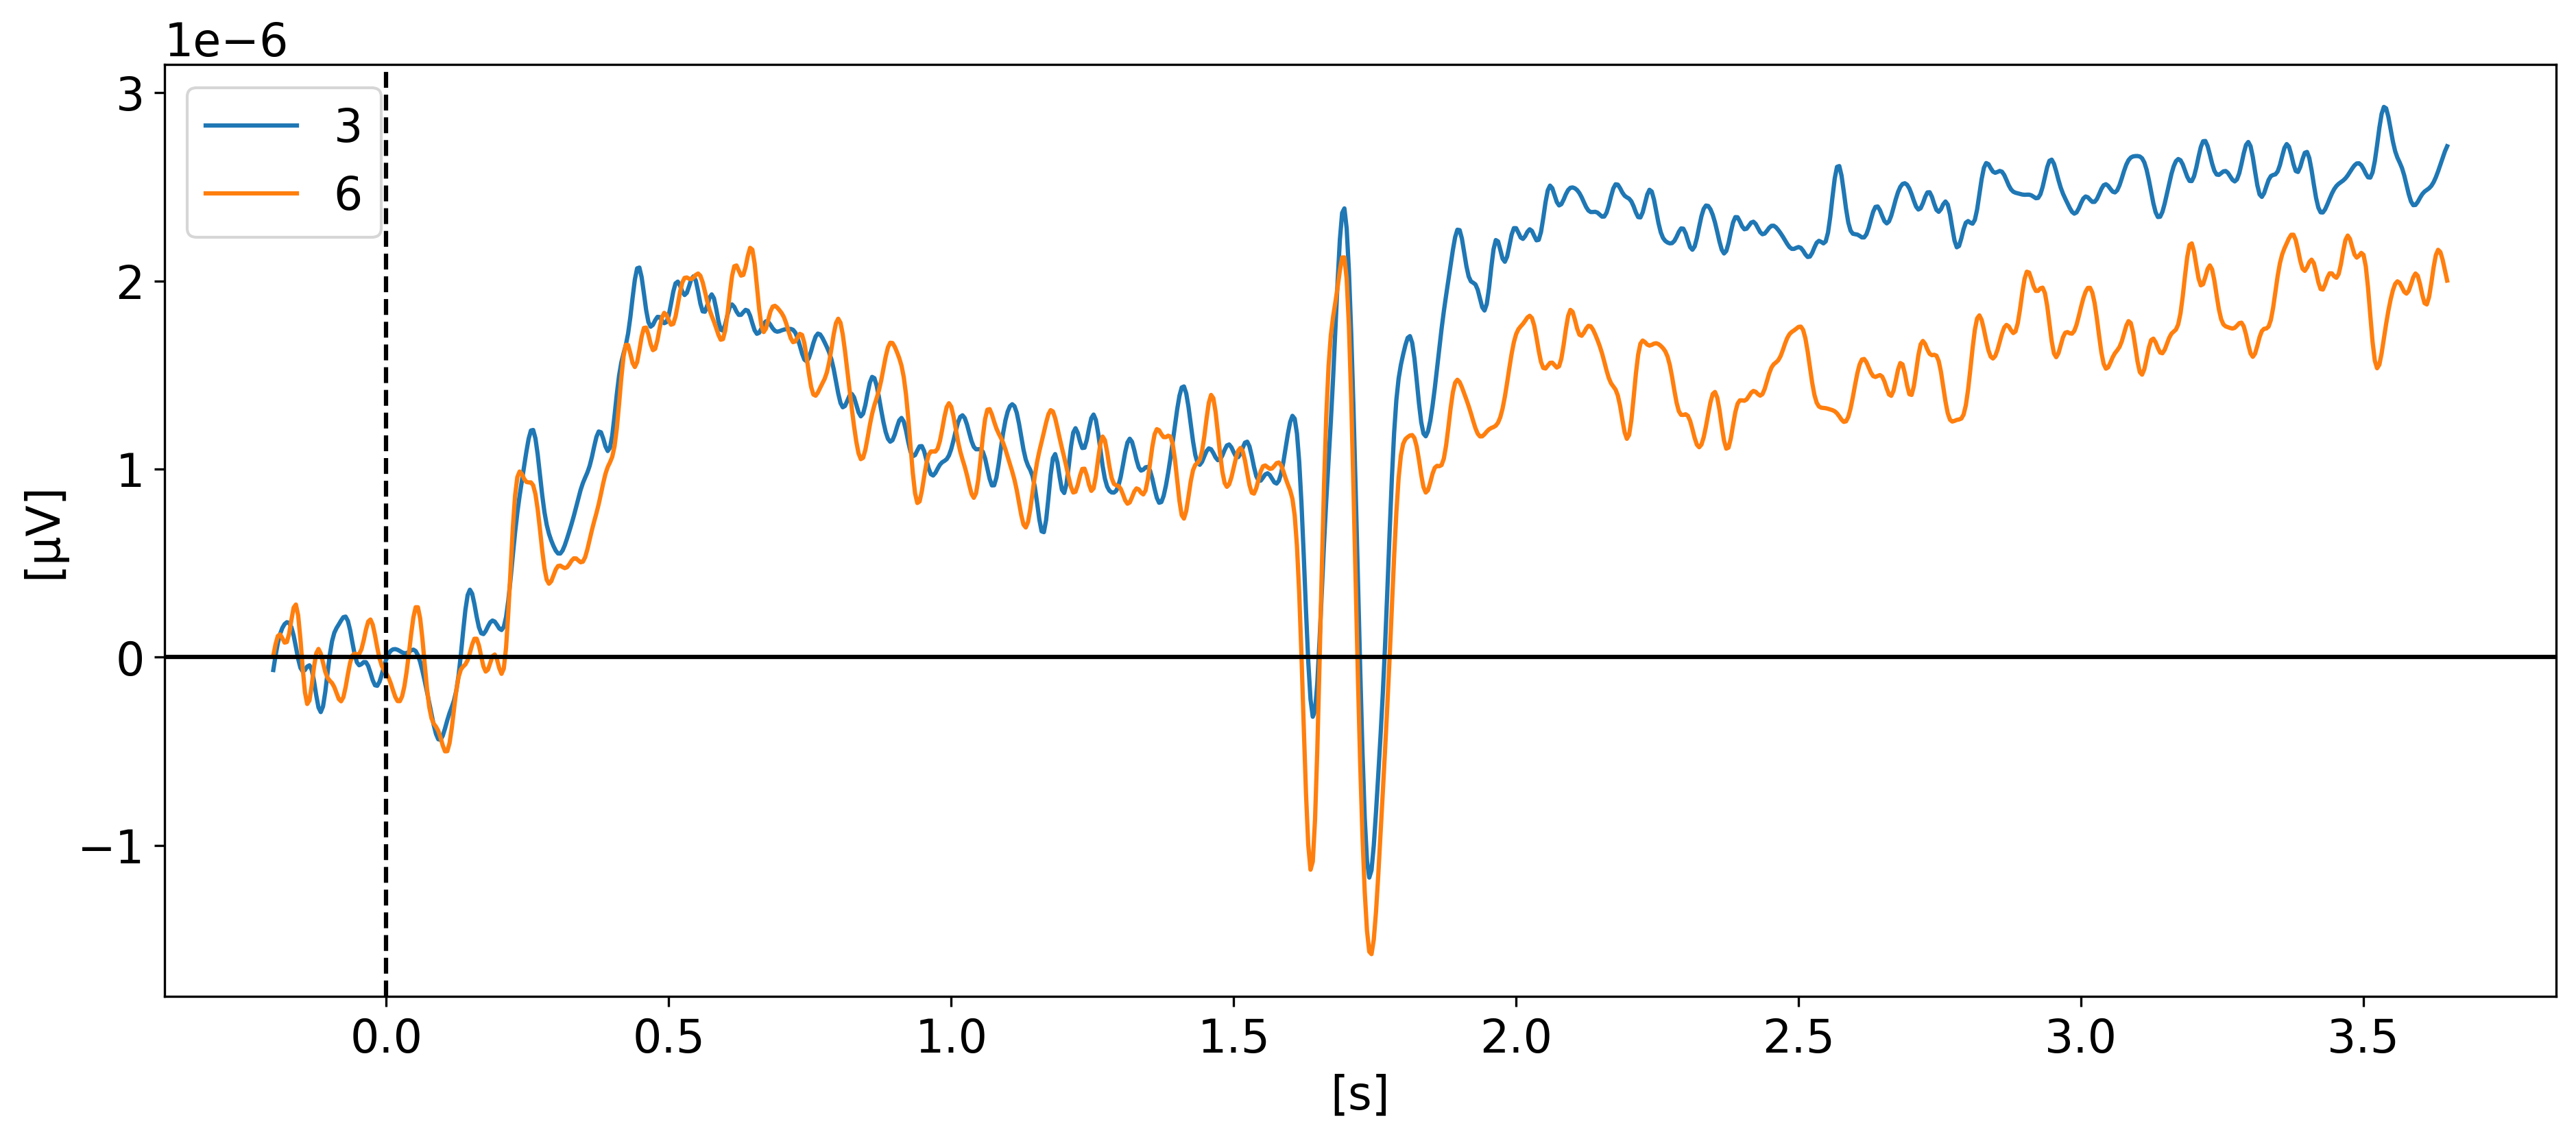

In [9]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 6), dpi=300)
#plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['3'].mean(0), label='3')
plt.plot(times, cda_all['6'].mean(0), label='6')
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
#plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.savefig("./Adam-2018_CDA-reprod.png", dpi=300, format='png')